In [6]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from torch.optim import Adam
import numpy as np
from tqdm.auto import tqdm
import umap
import umap.plot
import pandas as pd
from warnings import filterwarnings

In [7]:
fmnist_train = datasets.FashionMNIST(root='Fashion_mnist/',train=True,transform=ToTensor(),download=False)
fmnist_test  = datasets.FashionMNIST(root='Fashion_mnist/',train=False,transform=ToTensor(),download=False)

In [8]:
fmnist_train_loader = DataLoader(dataset=fmnist_train,batch_size=32)
fmnist_test_loader = DataLoader(dataset=fmnist_test,batch_size=32)

In [9]:
filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from helpers import visualize_dataset

In [11]:
batch_idx, (example_data,example_target) = next(enumerate(fmnist_test_loader))

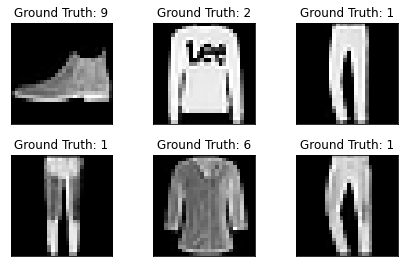

In [13]:
visualize_dataset(example_data=example_data,example_targets=example_target,channel_size=1)

# Conv-Linear VAE

Here we have an encoder function that uses convolutional layers and a decoder function that uses linear layers.

In [21]:
class ConvVAE(nn.Module):
    
    def __init__(self,latent_dim=200):
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1,out_channels=2,stride=1,kernel_size=3), #28x28x1 --> 26x26x2
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=2,out_channels=4,stride=2,kernel_size=4), #26x26x2 --> 12x12x4
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=4,out_channels=4,stride=1,kernel_size=3), #12x12x4 --> 10x10x4
            nn.LeakyReLU(),
        )
        
        
        self.mean    = nn.Linear(400,latent_dim)
        self.log_var = nn.Linear(400,latent_dim)
        self.linear  = nn.Linear(latent_dim,400) 
            
        self.decoder = nn.Sequential(
                nn.LeakyReLU(),
                nn.Linear(400,512),
                nn.LeakyReLU(),
                nn.Linear(512,28*28),
                nn.LeakyReLU()
        )
        
    def reparameterize(self,z_mean,z_log_var):
        
        eps = torch.randn(z_mean.size(0),z_mean.size(1))
        z = z_mean + torch.exp(z_log_var/2) * eps
        
        return z
        
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = x.view(x.size(0),-1)
        z_mean, z_log_var = self.mean(x), self.log_var(x)
        encoded = self.reparameterize(self.mean(x), self.log_var(x))
        x = self.linear(encoded)
        decoded = self.decoder(x)
        
        
        return encoded, z_mean, z_log_var, decoded 

In [22]:
def conv_train(model,train_dataloader,optimizer,device,loss_fn,EPOCH=30):
    
    with tqdm(total = len(train_dataloader) * EPOCH) as tt:
        
        model.train()
        model = model.to(device)
        
        for epoch in range(EPOCH):
            
            total_loss, batch_count = 0, 0
            
            for idx,(batch,_) in enumerate(train_dataloader):
                
                batch = batch.to(device)
                
                encoded, z_mean, z_log_var, reconstruction = model(batch)
                
                loss = loss_fn(reconstruction,batch,z_mean,z_log_var)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
                total_loss += loss.item()
                batch_count += 1
                tt.update()
                
            total_loss = total_loss / batch_count
            print(f'{total_loss}')


In [23]:
def vae_loss(decoded,x,z_mean,z_log_var):
    
    x = x.view(x.size(0),-1)
    
    recons = F.mse_loss(decoded, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    
    return recons + kl

In [24]:
#conv_vae_model = ConvVAE()
#optimizer = torch.optim.Adam(conv_vae_model.parameters(), lr=0.001)  

In [25]:
#conv_train(model=conv_vae_model,train_dataloader=fmnist_train_loader,optimizer=optimizer,loss_fn=vae_loss,device=device,EPOCH=20)
vae_model = torch.load('models/conv_linear_vae.pt',map_location=torch.device('cpu')) # map_location

In [26]:
def generate_random_imgs_conv(model,nsample=12):
    
    rand_features = torch.randn(nsample, 200)
    rand_features = rand_features.to(device)
    x = model.linear(rand_features)
    rand_generated = model.decoder(x)
    
    images = rand_generated.view(nsample,1,28,28)
    images = images.cpu().detach().numpy()
    
    for i in range(12):
            plt.subplot(3,4,i+1)
            plt.tight_layout()
            plt.imshow(images[i][0],cmap='gray')
            plt.xticks([])
            plt.yticks([])
    

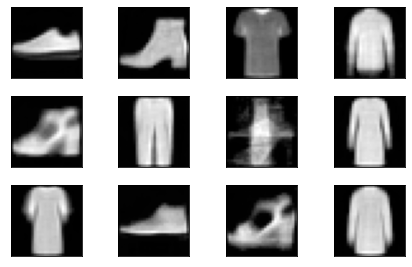

In [27]:
generate_random_imgs_conv(model=vae_model)